In [113]:
import numpy as np
import torch
import torch.nn as nn
from torch import nn, Tensor
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

In [2]:
class FCNet(nn.Module): # type1 - fully connected layers
    def __init__(self, D_in, D_out, input_shape):
        # D_in - dimension of input channel, should be 3 for point cloud coordinates
        # D_out - number of classes label
        # k - number of rays
        # N - number of points on one ray
        super(FCNet, self).__init__()
        self.fc1 = nn.Linear(input_shape[0]*input_shape[1]*input_shape[2], 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, D_out)
        self.dropout = nn.Dropout(p=0.3)
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.bn3 = nn.BatchNorm1d(128)
        self.relu = nn.ReLU()

#         self.final_layer = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.contiguous().view(-1,self.num_flat_features(x))
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = F.relu(self.bn3(self.dropout(self.fc3(x))))
        x = self.fc4(x)
#         x = self.final_layer(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    def method_of_pred(self, x):
        pass

In [152]:
class oneDVerConvNet(nn.Module): # type3 - 1D Vertical Convolution
    def __init__(self, D_in, D_out, input_shape, b_size):
        # input_shape: without batch dimension
        # b_size: batch size
        super(oneDVerConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(D_in, 16, (3,1), stride = (1,1), padding = (1,0)),
            # nn.BatchNorm2d(16), # no batch
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (2,1), stride = (2,1)))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size = (3,1), stride = (1,1), padding= (1,0)),
            # nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (2,1), stride = (2,1)))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 256, kernel_size = (3,1), stride = (1,1), padding= (1,0)),
            # nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (2,1), stride = (2,1)))
        self.layer4 = nn.Sequential(
            nn.Conv2d(256, 1024, kernel_size = (3,1), stride = (1,1), padding= (1,0)),
            # nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (2,1), stride = (2,1)))
        self.drop_out = nn.Dropout()
        n_size = self._get_conv_output(input_shape, b_size)
        # print(n_size)
 #       self.fc1 = nn.Linear(n_size, 256)
 #        self.fc1 = nn.Linear(1024, 256)
 #        self.fc2 = nn.Linear(256, 64)
 #        self.fc3 = nn.Linear(64,D_out)
        self.transform1 = nn.Conv2d(n_size, 256, kernel_size = (1,1), stride = (1,1), padding=0)
        self.transform2 = nn.Conv2d(256, 64, kernel_size = (1,1), stride = (1,1), padding=0)
        self.transform3 = nn.Conv2d(64, D_out, kernel_size = (1,1), stride = (1,1), padding=0)
        # self.bn1 = nn.BatchNorm1d(256)
        # self.bn2 = nn.BatchNorm1d(64)

    def _get_conv_output(self, shape, b_size):
        input = Variable(torch.rand(b_size, *shape))
        output_feat = self._forward_features(input)
        n_size = output_feat.data.view(b_size, -1).size(1)
        return n_size

    def _forward_features(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # print(x.shape) # shape = (b_size, feature=1024, H=1, W = 54)
        x = torch.max(x,3)[0]
        return x

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # x = torch.max(x,3)[0] # questionable maybe do along [1]
        # print(x.shape) # shape = (b_size, feature=1024, H=1) after max
        #print(x.data.size())
        # x = x.view(-1,self.num_flat_features(x))
#        print(x.data.size())
#         x = F.relu(self.bn1(self.fc1(x)))
#         x = F.relu(self.bn2(self.drop_out(self.fc2(x))))
        x = F.relu(self.transform1(x))
        x = F.relu(self.drop_out(self.transform2(x)))
        x = self.transform3(x)
##        return x, new_features, contribution
        return x.squeeze()

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


In [ ]:
class train_NN():
    def __init__(
        self,
        optimizer,
        net,
    ):
        self.optimizer = optimizer
        self.net = net
        self.n_jobs = n_jobs
        self.positive = positive

    def fit(self, X, y, nepoch=10):
        for epoch in range(nepoch):
            running_loss = 0
            self.net.train()
            np.random.seed()
            self.optimizer.zero_grad()
            for (i, data) in enumerate(X):
                data, label = X, y[i]
                label = label.view(-1)
                num_examples = label.size()[0] # need this because it's not always the batch size

                self.optimizer.zero_grad()

        outputs = net(smatrix)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())

In [144]:
import pandas as pd
from pipeline import Dataset, backtest
from matplotlib import pyplot as plt
from datatools import data_quantization, check_dataframe, extract_market_data
from sklearn.model_selection import TimeSeriesSplit
from tqdm.auto import tqdm, trange
from pandas import Series, DataFrame, MultiIndex
from visualization.metric import Performance
from sklearn.metrics import r2_score
from visualization.metric import plot_performance

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
dataset = Dataset.load('../../data/parsed')
# dataset = load_mini_dataset('../../data/parsed_mini/')

In [140]:
quantized_fundamental, _ = data_quantization(dataset.fundamental)
df = pd.concat([quantized_fundamental, dataset.fundamental, dataset.ref_return], axis=1).dropna()
quantile_feature = ['turnoverRatio_QUANTILE', 'transactionAmount_QUANTILE', 'pb_QUANTILE', 'ps_QUANTILE',
                            'pe_ttm_QUANTILE', 'pe_QUANTILE', 'pcf_QUANTILE']
original_feature = ['turnoverRatio', 'transactionAmount', 'pb', 'ps', 'pe_ttm', 'pe', 'pcf']

check_dataframe(df, expect_index=['day','asset'])


Indices matched
Features matched
DataFame is all good for the tests


In [142]:
df['return_known'] = df['return'].shift(2*54)
df=df.dropna()

In [130]:
original_feature = ['turnoverRatio', 'transactionAmount', 'pb', 'ps', 'pe_ttm', 'pe', 'pcf','return_known']
quantile_feature = ['turnoverRatio_QUANTILE', 'transactionAmount_QUANTILE', 'pb_QUANTILE', 'ps_QUANTILE',
                            'pe_ttm_QUANTILE', 'pe_QUANTILE', 'pcf_QUANTILE', 'return_known']

## Training always loop over all available data

In [207]:
# Hyperparameter
n_splits = 995
# n_epoch = 10
learning_rate = 0.1
lookback_window = 16
# Define loss
# criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()
# Define network
 # net = oneDVerConvNet(D_in=7, D_out=1, input_shape=(7,lookback_window,54), b_size=1)
net = oneDVerConvNet(D_in=7, D_out=1, input_shape=(7,lookback_window,54), b_size=1)
# Define the optimizier
# optimizer = optim.LBFGS(net.parameters(), lr=learning_rate)
optimizer = optim.Adam(net.parameters(), lr=learning_rate, betas = (0.9, 0.999))
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 100, gamma = 0.5)


loss_list = []
# label_train_list = []
# test_list2 = []
# test_score_old = 0

days = df.index.get_level_values('day').unique()
tscv = TimeSeriesSplit(n_splits=min(n_splits, len(days)))
pbar = tqdm(tscv.split(days), total=tscv.n_splits)

cum_y_val_true = Series(dtype=float)
cum_y_val_prediction = Series(dtype=float)
performance = Performance()
# feature_columns = quantile_feature
feature_columns = original_feature
return_column = ['return']


# for epoch in range(n_epoch):
for fold, (train, val) in enumerate(pbar):
    # X, _ = data_quantization(df[original_feature])
    running_loss = 0
    net.train()
    np.random.seed()
    days_train = days[train]

    if len(days_train) < 2:
        print('Skipping this fold since we cannot truncate the last day.')
        continue
    if (lookback_window is not None) and (len(days_train) > lookback_window):
        cum_y_train_true = Series(dtype=float)
        cum_y_train_prediction = Series(dtype=float)
        for i in range(lookback_window, len(days_train)):
            days_train_valid = days_train[i-lookback_window:i] # last ends at valid-day-2
            X_train, y_train_true = df.loc[(days_train_valid,), :][feature_columns], df.loc[(days_train_valid[-1]),:][return_column]

            X_np = X_train.swaplevel(1,0).sort_index(ascending=True).to_numpy().astype(np.float32)
            # shape (asset, days, feature) -> (ft, days, asset)
            X_np_tensor = X_np.reshape(54,lookback_window,-1).transpose([2,1,0])
            X_np_tensor = X_np_tensor[np.newaxis,:]  # add batch dimension
            X_torch = torch.from_numpy(X_np_tensor)
            labels = torch.tensor(y_train_true['return'].values).to(torch.float)
            #
            # def closure():
            #     optimizer.zero_grad()
            #     outputs=net(X_torch)
            #     loss = criterion(outputs, labels)
            #     loss.backward()
            #     return loss

            optimizer.zero_grad()
            outputs = net(X_torch)
            loss = criterion(outputs, labels)
            loss.backward()
            # optimizer.step(closure) # need closure for LBFGS
            optimizer.step()
            cum_y_train_prediction = pd.concat([cum_y_train_prediction, Series(outputs.detach().numpy())])
            cum_y_train_true = pd.concat([cum_y_train_true, y_train_true.squeeze()], ignore_index=True)

        performance[fold,'train_r2'] = r2_score(cum_y_train_prediction, cum_y_train_true)
        if fold % 100 == 0:
            print('Fold [{}/{}], Loss: {:.4f}, cum_train_r2: {:.2f}%'.format(fold, len(pbar), loss.item(), r2_score(cum_y_train_prediction, cum_y_train_true)))
        # Validation:
        days_val = days[int(val)-lookback_window:int(val)]

        X_val, y_val_true = df.loc[(days_val,), :][feature_columns], df.loc[(days_val[-1],), :][return_column]
        net.eval()
        net.train(False)
        with torch.no_grad():
            X_np_val = X_val.swaplevel(1,0).sort_index(ascending=True).to_numpy().astype(np.float32)
            # shape (asset, days, feature) -> (ft, days, asset)
            X_np_val_tensor = X_np_val.reshape(54,lookback_window,-1).transpose([2,1,0])
            X_np_val_tensor = X_np_val_tensor[np.newaxis,:]  # add batch dimension
            X_torch_val = torch.from_numpy(X_np_val_tensor)
            labels = torch.tensor(y_val_true['return'].values).to(torch.float)

            outputs_val = net(X_torch_val)
            cum_y_val_prediction = pd.concat([cum_y_val_prediction, Series(outputs_val.numpy())])
            cum_y_val_true = pd.concat([cum_y_val_true, y_val_true.squeeze()], ignore_index=True)

        val_r2 = r2_score(y_val_true.squeeze(), Series(outputs_val.numpy())) # Do I need index for series to corr or R2?
        performance[fold, 'val_r2'] = val_r2
        val_pearson = y_val_true.squeeze().corr(Series(outputs_val.numpy()))
        performance[fold, 'val_pearson'] = val_pearson
        val_cum_r2 = r2_score(cum_y_val_true, cum_y_val_prediction)
        performance[fold, 'val_cum_r2'] = val_cum_r2
        val_cum_pearson = cum_y_val_true.corr(cum_y_val_prediction)
        performance[fold, 'val_cum_pearson'] = val_cum_pearson

        pbar.set_description(f'Fold {fold}, val_cum_r2={val_cum_r2:.4f}, val_cum_pearson={val_cum_pearson:.4f}')

    else:
        pass
    # if fold > 20:
    #     break
    # X_train, y_train_true = df.loc[(days_train_valid,), :][feature_columns], df.loc[(days_train_valid,), :][return_column]
    # X_val, y_val_true = df.loc[(days_val,), :][feature_columns], df.loc[(days_val,), :][return_column]

    #

  0%|          | 0/995 [00:00<?, ?it/s]

Skipping this fold since we cannot truncate the last day.
Fold [100/995], Loss: 0.3705, cum_train_r2: -0.58%
Fold [200/995], Loss: 0.0517, cum_train_r2: -1.03%
Fold [300/995], Loss: 0.0010, cum_train_r2: -0.76%
Fold [400/995], Loss: 0.0006, cum_train_r2: -0.88%
Fold [500/995], Loss: 0.0008, cum_train_r2: -3.21%
Fold [600/995], Loss: 0.0014, cum_train_r2: -0.98%


KeyboardInterrupt: 

## Training only use the current data (one data one training each fold)

In [216]:
# Hyperparameter
n_splits = 995
n_epoch = 3
learning_rate = 0.03
lookback_window = 16
# Define loss
# criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()
# Define network
 # net = oneDVerConvNet(D_in=7, D_out=1, input_shape=(7,lookback_window,54), b_size=1)
net = oneDVerConvNet(D_in=7, D_out=1, input_shape=(7,lookback_window,54), b_size=1)
# Define the optimizier
optimizer = optim.LBFGS(net.parameters(), lr=learning_rate)
# optimizer = optim.Adam(net.parameters(), lr=learning_rate, betas = (0.9, 0.999))
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 100, gamma = 0.5)


loss_list = []
# label_train_list = []
# test_list2 = []
# test_score_old = 0

for epoch in range(n_epoch):
    days = df.index.get_level_values('day').unique()
    tscv = TimeSeriesSplit(n_splits=min(n_splits, len(days)))
    pbar = tqdm(tscv.split(days), total=tscv.n_splits)

    cum_y_val_true = Series(dtype=float)
    cum_y_val_prediction = Series(dtype=float)
    performance = Performance()
    # feature_columns = quantile_feature
    feature_columns = original_feature
    return_column = ['return']


    # for epoch in range(n_epoch):
    for fold, (train, val) in enumerate(pbar):
        # X, _ = data_quantization(df[original_feature])
        running_loss = 0
        net.train()
        np.random.seed()
        days_train = days[train]

        if len(days_train) < 2:
            print('Skipping this fold since we cannot truncate the last day.')
            continue
        if (lookback_window is not None) and (len(days_train) > lookback_window):
            cum_y_train_true = Series(dtype=float)
            cum_y_train_prediction = Series(dtype=float)

            days_train_valid = days_train[-lookback_window-1:-1] # last ends at valid-day-2
            X_train, y_train_true = df.loc[(days_train_valid,), :][feature_columns], df.loc[(days_train_valid[-1]),:][return_column]

            X_np = X_train.swaplevel(1,0).sort_index(ascending=True).to_numpy().astype(np.float32)
                # shape (asset, days, feature) -> (ft, days, asset)
            X_np_tensor = X_np.reshape(54,lookback_window,-1).transpose([2,1,0])
            X_np_tensor = X_np_tensor[np.newaxis,:]  # add batch dimension
            X_torch = torch.from_numpy(X_np_tensor)
            labels = torch.tensor(y_train_true['return'].values).to(torch.float)
                #
            def closure():
                optimizer.zero_grad()
                outputs=net(X_torch)
                loss = criterion(outputs, labels)
                loss.backward()
                return loss

            optimizer.zero_grad()
            outputs = net(X_torch)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step(closure) # need closure for LBFGS
            # optimizer.step()
            cum_y_train_prediction = pd.concat([cum_y_train_prediction, Series(outputs.detach().numpy())])
            cum_y_train_true = pd.concat([cum_y_train_true, y_train_true.squeeze()], ignore_index=True)

            performance[fold,'train_r2'] = r2_score(cum_y_train_prediction, cum_y_train_true)
            if fold % 100 == 0:
                print('Fold [{}/{}], Loss: {:.4f}, cum_train_r2: {:.2f}%'.format(fold, len(pbar), loss.item(), r2_score(cum_y_train_prediction, cum_y_train_true)))
            # Validation:
            days_val = days[int(val)-lookback_window:int(val)]

            X_val, y_val_true = df.loc[(days_val,), :][feature_columns], df.loc[(days_val[-1],), :][return_column]
            net.eval()
            net.train(False)
            with torch.no_grad():
                X_np_val = X_val.swaplevel(1,0).sort_index(ascending=True).to_numpy().astype(np.float32)
                # shape (asset, days, feature) -> (ft, days, asset)
                X_np_val_tensor = X_np_val.reshape(54,lookback_window,-1).transpose([2,1,0])
                X_np_val_tensor = X_np_val_tensor[np.newaxis,:]  # add batch dimension
                X_torch_val = torch.from_numpy(X_np_val_tensor)
                labels = torch.tensor(y_val_true['return'].values).to(torch.float)

                outputs_val = net(X_torch_val)
                cum_y_val_prediction = pd.concat([cum_y_val_prediction, Series(outputs_val.numpy())])
                cum_y_val_true = pd.concat([cum_y_val_true, y_val_true.squeeze()], ignore_index=True)

            val_r2 = r2_score(y_val_true.squeeze(), Series(outputs_val.numpy())) # Do I need index for series to corr or R2?
            performance[fold, 'val_r2'] = val_r2
            val_pearson = y_val_true.squeeze().corr(Series(outputs_val.numpy()))
            performance[fold, 'val_pearson'] = val_pearson
            val_cum_r2 = r2_score(cum_y_val_true, cum_y_val_prediction)
            performance[fold, 'val_cum_r2'] = val_cum_r2
            val_cum_pearson = cum_y_val_true.corr(cum_y_val_prediction)
            performance[fold, 'val_cum_pearson'] = val_cum_pearson

            pbar.set_description(f'Fold {fold}, val_cum_r2={val_cum_r2:.4f}, val_cum_pearson={val_cum_pearson:.4f}')

        else:
            pass
        scheduler.step() ### !!!!!
        # if fold > 20:
        #     break
        # X_train, y_train_true = df.loc[(days_train_valid,), :][feature_columns], df.loc[(days_train_valid,), :][return_column]
        # X_val, y_val_true = df.loc[(days_val,), :][feature_columns], df.loc[(days_val,), :][return_column]

        #

  0%|          | 0/995 [00:00<?, ?it/s]

Skipping this fold since we cannot truncate the last day.


/Users/lewisliu/micromamba/envs/DataScience/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Fold [100/995], Loss: 4562.5898, cum_train_r2: -0.71%
Fold [200/995], Loss: 1226.9479, cum_train_r2: -0.79%
Fold [300/995], Loss: 868.2052, cum_train_r2: -0.61%
Fold [400/995], Loss: 507.5324, cum_train_r2: -1.08%
Fold [500/995], Loss: 189.3078, cum_train_r2: -1.28%
Fold [600/995], Loss: 190.2297, cum_train_r2: -1.39%
Fold [700/995], Loss: 860.8625, cum_train_r2: -0.61%
Fold [800/995], Loss: 705.0922, cum_train_r2: -0.88%
Fold [900/995], Loss: 378.9142, cum_train_r2: -0.69%


  0%|          | 0/995 [00:00<?, ?it/s]

Skipping this fold since we cannot truncate the last day.
Fold [100/995], Loss: 3767.4880, cum_train_r2: -0.82%
Fold [200/995], Loss: 1265.0452, cum_train_r2: -0.96%
Fold [300/995], Loss: 499.5302, cum_train_r2: -1.29%
Fold [400/995], Loss: 669.6657, cum_train_r2: -0.67%
Fold [500/995], Loss: 183.0281, cum_train_r2: -1.18%
Fold [600/995], Loss: 228.0203, cum_train_r2: -1.73%
Fold [700/995], Loss: 860.3463, cum_train_r2: -0.91%
Fold [800/995], Loss: 782.5058, cum_train_r2: -0.84%
Fold [900/995], Loss: 340.9067, cum_train_r2: -1.14%


  0%|          | 0/995 [00:00<?, ?it/s]

Skipping this fold since we cannot truncate the last day.
Fold [100/995], Loss: 4682.9399, cum_train_r2: -0.68%
Fold [200/995], Loss: 867.1305, cum_train_r2: -0.75%
Fold [300/995], Loss: 539.1282, cum_train_r2: -1.12%
Fold [400/995], Loss: 534.5932, cum_train_r2: -0.78%
Fold [500/995], Loss: 314.9617, cum_train_r2: -1.14%
Fold [600/995], Loss: 241.6684, cum_train_r2: -1.30%
Fold [700/995], Loss: 986.4664, cum_train_r2: -0.95%
Fold [800/995], Loss: 5503.8125, cum_train_r2: -0.15%
Fold [900/995], Loss: 365.3145, cum_train_r2: -0.94%


In [137]:
days_train_valid[-1]

277

In [99]:
X_np = X_train.swaplevel(1,0).sort_index(ascending=True).to_numpy().astype(np.float32)

In [33]:
X_np

array([[ 9,  9,  6, ...,  6,  5,  1],
       [ 9,  8,  6, ...,  3,  3,  3],
       [10, 10,  6, ...,  3,  3,  3],
       ...,
       [ 4,  3,  5, ...,  2,  3,  6],
       [ 2,  1,  5, ...,  2,  3,  6],
       [ 7,  5,  5, ...,  3,  3,  6]])

In [100]:
# shape (asset, days, feature) -> (ft, days, asset)
X_np_tensor = X_np.reshape(54,16,-1).transpose([2,1,0])


In [50]:
# Conv2d input: (B=1, D, H, W)
# X_np_tensor: (ft, days, asset)
X_np_tensor[:,:,0]

array([[ 9,  9, 10, 10, 10, 10, 10, 10, 10,  9],
       [ 9,  8, 10, 10, 10, 10, 10, 10,  9,  9],
       [ 6,  6,  6,  6,  6,  6,  6,  6,  6,  6],
       [ 5,  4,  5,  5,  5,  5,  5,  5,  5,  5],
       [ 6,  3,  3,  4,  3,  3,  3,  3,  3,  3],
       [ 5,  3,  3,  4,  4,  4,  4,  4,  4,  4],
       [ 1,  3,  3,  3,  3,  3,  3,  3,  3,  3]])

In [101]:
X_np_tensor = X_np_tensor[np.newaxis,:] # add

In [125]:
X_torch = torch.from_numpy(X_np_tensor)
net = oneDVerConvNet(D_in=7, D_out=1, input_shape=(7,16,54), b_size=1)
result = net(X_torch)

In [108]:
X_torch.dtype


torch.float32

In [106]:
X_np.dtype

dtype('float32')

In [105]:
X_np_tensor.dtype


dtype('float32')

In [147]:
outputs.dtype

torch.float32

In [148]:
labels.dtype


torch.float64

In [159]:
df.loc[(days_train_valid[-1]),:][return_column]

,return
asset,
0,0.004256
1,0.006398
2,0.020687
3,0.038906
4,0.067663
5,0.031702
6,0.013807
7,0.001451
8,0.025641


In [185]:
cum_y_train_true = Series(dtype=float)


In [186]:
cum_y_train_true = pd.concat([cum_y_train_true, y_train_true_series])

In [184]:
y_train_true_series = y_train_true.squeeze()

In [180]:
cum_y_train_true

,0,1
0,NaN,0.004256
1,NaN,0.006398
2,NaN,0.020687
3,NaN,0.038906
4,NaN,0.067663
5,NaN,0.031702
6,NaN,0.013807
7,NaN,0.001451
8,NaN,0.025641
9,NaN,0.035014


In [181]:
y_train_true.index

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
            51, 52, 53],
           dtype='int64', name='asset')

In [191]:
y_val_true.corr(Series(outputs_val.numpy()))

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [195]:
test = net(X_torch)


In [196]:
len(pbar)

995

In [202]:

cum_y_train_prediction.isna()

0     False
1     False
2     False
3     False
4     False
      ...  
49     True
50     True
51     True
52     True
53     True
Length: 2538, dtype: bool

The ending score for metric train_r2 is: -1.1653e+00
The ending score for metric val_cum_r2 is: -4.8179e+05
The ending score for metric val_cum_pearson is: 9.0559e-02


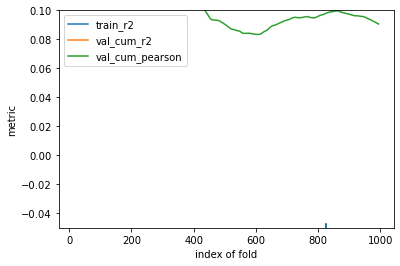

In [217]:
plt.figure()
# plot_performance(performance, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
plot_performance(performance, metrics_selected=['train_r2', 'val_cum_pearson','val_cum_r2'])
plt.show()

In [218]:
pwd

'/Users/lewisliu/Desktop/Study/Graduate_Study_Austin/Career/Practice/qids-2023-comp/playground/shockspeare'

In [219]:
model_path = '../../model/dump/1DConv'
torch.save(net.state_dict(), model_path)


In [221]:
from qids_lib import QIDS
from pipeline.backtest import evaluation_for_submission


dataset = Dataset.load('../data/parsed')
df = pd.concat([dataset.fundamental, extract_market_data(dataset.market)], axis=1).dropna()
df['return_known'] = df['return'].shift(2*54)
df=df.dropna()
f_quantile_feature = ['turnoverRatio_QUANTILE', 'transactionAmount_QUANTILE', 'pb_QUANTILE', 'ps_QUANTILE',
                      'pe_ttm_QUANTILE', 'pe_QUANTILE', 'pcf_QUANTILE', 'return_known']
m_quantile_feature = ['avg_price_QUANTILE', 'volatility_QUANTILE', 'mean_volume_QUANTILE', 'return_known']
# feature = ['turnoverRatio', 'transactionAmount', 'pb', 'ps', 'pe_ttm', 'pe', 'pcf', 'avg_price', 'volatility',
#            'mean_volume']



# q_df, _ = data_quantization(dataset.fundamental)
# full_df = pd.concat([q_df, dataset.ref_return], axis=1).dropna()
# model = linear_model(full_df[f_quantile_feature], full_df['return'])

qids = QIDS(path_prefix='../')
performance = evaluation_for_submission(linear_model, original_feature, dataset=dataset, df=df, qids=qids,
                                        lookback_window=200)

